In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from scipy.stats import shapiro, anderson, boxcox
import numpy as np
import math
import seaborn as sns

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Definição de constantes

In [3]:
l_drop = [#'rotulo',
          'id_reforma',
          'sdv002',
          'sdc002',
          #'mdv001_1',
          #'mdv001_2',
          #'mdv001_3',
          #'mdv001_4',
          'sdu001_1',
          'sdu001_2',
          'TipoAlarmeReleResistencia_id_tipo',
          'TipoAlarmeResistencia_id_tipo',
          'id_reacao','data_hora_reforma'
          ]

d_rename = {'sdp002':'pressure',
            'sdt002':'reactor temperature',
            'sdt003':'pre-reactor temperature',
            'sdu002_1':'humidity',
            'sdu002_2':'outlet temperature 1',
            'rotulo': 'label',
            'mdv001_1':'outlet pressure',
            'mdv001_2':'volume flow',
            'mdv001_3':'mass flow',
            'mdv001_4':'outlet temperature 2'
            }

l_available = ['pressure',
               'reactor temperature',
               'pre-reactor temperature',
               'humidity',
               'outlet temperature 1',
               'label']
l_missing = ['outlet pressure',
             'volume flow',
             'mass flow',
             'outlet temperature']

l_new_avaliable = ['number data', 'SMA pressure forecast']

SMA_period  = 8 #


In [4]:
def recordsMinute(df):

    df['timestamp'] = pd.to_datetime(df['data_hora_reforma'], errors='coerce')
    df.set_index('timestamp', inplace=True)
    counts_per_minute = df.resample('min').size()

    #media_registros_por_minuto = counts_per_minute.mean()
    count = counts_per_minute.describe()
    df = df.reset_index(drop=True)
    return count, df


Leitura dos dados e Pré-processamento

In [5]:
#dir = '/content/drive/MyDrive/data/BASES/finalVersion/'
#dir = 'C:/Users/renan/Documents/dryReforming_dataset/dryReforming_dataset/dataset/'
dir = 'dataset/'
idBase = [17,21,22,23,24,26,27,30,39]
dfs = []
days = []
dfs_flow = []
days_flow = []
l_reg_minute = []
for i in (17,21,22,23,24,26,27,30,39):
  df = pd.read_csv(dir+'base'+str(i)+'_noFilter.csv')#'base'+str(i)+'_final.csv')
  day= df['data_hora_reforma'].str[:10][0]
  days.append(day)
  count, df = recordsMinute(df)#
  l_reg_minute.append(count)#
  df = df.drop(l_drop, axis=1)
  df = df.rename(columns=d_rename)
  df['number data'] = range(len(df))
  df['SMA pressure forecast'] = df['pressure'].shift(-SMA_period).rolling(SMA_period).mean()
  if df['outlet pressure'][0] != -1:
    df['volume flow'] = df['volume flow'].mask(df['volume flow'] < 0, 0)
    df['mass flow'] = df['mass flow'].mask(df['mass flow'] < 0, 0)
    dfs_flow.append(df)
    days_flow.append(day)
  df = df[l_available + l_new_avaliable]
  dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all_flow = pd.concat(dfs_flow, ignore_index=True)

days_flow


['2024-01-23', '2024-03-14', '2024-03-15']

### Análise da quantidade de registros por mintuto nas bases

A média 2.45, mas a mediana 2.88 e o 3º quartil (75%) teve 3 registros por minuto

**Pensando na possibilidade de fazer uma previsão da pressão:**
- Para uma previsão de 3 minutos seria necessário avançar aproximadamente 8 registros a frente.
- Também é necessário considerar que existem minutos nas bases que não há registros. 
- Em um modelo de previsão este intervalos que não há registros precisam de um processamento independente. 

In [6]:
dfCountRegMinute = pd.DataFrame(data=l_reg_minute)
dfCountRegMinute

,count,mean,std,min,25%,50%,75%,max
0,556.0,2.510791,0.672410,0.0,2.0,3.0,3.0,3.0
1,563.0,2.383659,0.814820,0.0,2.0,3.0,3.0,3.0
2,511.0,2.217221,0.969019,0.0,2.0,2.0,3.0,3.0
3,1846.0,2.331528,0.897182,0.0,2.0,3.0,3.0,3.0
4,2223.0,2.535762,0.589782,0.0,2.0,3.0,3.0,3.0
5,2766.0,2.542661,0.583828,0.0,2.0,3.0,3.0,3.0
6,584.0,2.544521,0.586940,0.0,2.0,3.0,3.0,3.0
7,660.0,2.539394,0.588168,0.0,2.0,3.0,3.0,3.0
8,815.0,2.526380,0.587736,1.0,2.0,3.0,3.0,3.0


### Pontos sem coleta de dados

Durante o processo de coleta de dados alguns ponto foram perdidos devido à interferência da rede durante a comunicação de dados, congestionamento do canal de comunicação no microcontrolador ou falta de energia nos ambientes.
| # | Date       | Lost Collections |
|---|------------|------------------|
| 0 | 2024-01-23 | 13               |
| 1 | 2024-03-14 | 31               |
| 2 | 2024-03-15 | 53               |
| 3 | 2024-03-18 | 10               |
| 4 | 2024-03-25 | 05               |
| 5 | 2024-04-01 | 04               |
| 6 | 2024-04-09 | 01               |
| 7 | 2024-05-10 | 01               |
| 8 | 2024-10-11 | 00               |


In [7]:
def printBoxPlot(df_data, l_remove):
    num_columns = len(df_data.columns) - len(l_remove) # remove label and SMA pressure forecast
    num_rows = math.ceil(num_columns / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axs = axs.flatten()

    k = 0
    for i, column in enumerate(df_data.columns):
        if column not in l_remove:
            axs[i-k].boxplot(df_data[column].dropna())
            axs[i-k].set_title(f'{column}')
            axs[i-k].set_xlabel(f'{column}')
        else:
            k += 1

    for j in range(i-k+1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

### Análise Descritiva e boxplot
- Apresentamos a contagem de valores (count), a média (mean), desvio padrão (std) valor de cada quartil (25% - 1º quartil, 50% - mediana ou 2º quartil e 75% - 3º quartil), incluindo os valores mínimo (min) e máximo (max).
-  A média e o desvio padrão da temperatura do reator e do pré-reator são altas, indicando uma variação considerável. O valor mínimo e máximo também sao bem diferentes o que indica fases de operação diferentes, como aquecimento, operação e desligamento do reator. A mediana, o primeiro e o terceiro quartis são similares, o que indica que as temperaturas do reator e do pré-reator são aproximadamente constantes quando o reator está em operação.
- A umidade tem uma grande variação com um desvio padrão de 28.14 e uma amplitude de 12.4% a 99%. 
- A temperatura de saída do gás tem um máximo de 43.4°C e um mínimo de 22.4°C, o que sugere uma variação significativa. Possivelmente, valores mais altos são durante a operação do reator, pois passa pelo reator. Os valores mais baixos são quando o equipamento está nos outros estagios de uso do equipamento.
- Embora a média da pressão seja de 0.582487, com desvio padrão de 0.377408, o valor máximo de 2.58, que é consideravelmente mais alto que o valor médio. Isso sugere que em alguns momentos há um aumento significativo na pressão que pode estar associado a condições específicas de operação do reator de reforma, como o entupimento.
- Os valores da previsão de pressão com média móvel (SMA pressure forecast) estão bem próximos dos valores reais da pressão, pois os valores de previsão são derivados dos valores reais da pressão, conforme a seguinte equação, sendo SMA_period=8, e P o valor da pressão.

![texto ao](eq1.png)



In [8]:
df_all.describe()

,pressure,reactor temperature,pre-reactor temperature,humidity,outlet temperature 1,label,number data,SMA pressure forecast
count,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,26179.000000,26044.000000
mean,0.583907,707.310249,574.040605,58.424157,27.936315,0.974713,2186.164789,0.584828
std,0.377729,232.990959,190.841796,28.128918,2.766893,0.792018,1807.800573,0.376466
min,0.340000,0.000000,20.000000,12.400000,22.400000,0.000000,0.000000,0.340000
25%,0.380000,796.000000,650.000000,31.500000,26.000000,0.000000,727.000000,0.380000
50%,0.430000,797.000000,650.000000,58.200000,27.100000,1.000000,1527.000000,0.435000
75%,0.590000,801.000000,650.000000,87.500000,29.300000,2.000000,3481.500000,0.590000
max,2.580000,806.000000,654.000000,99.000000,43.400000,2.000000,7034.000000,2.572500


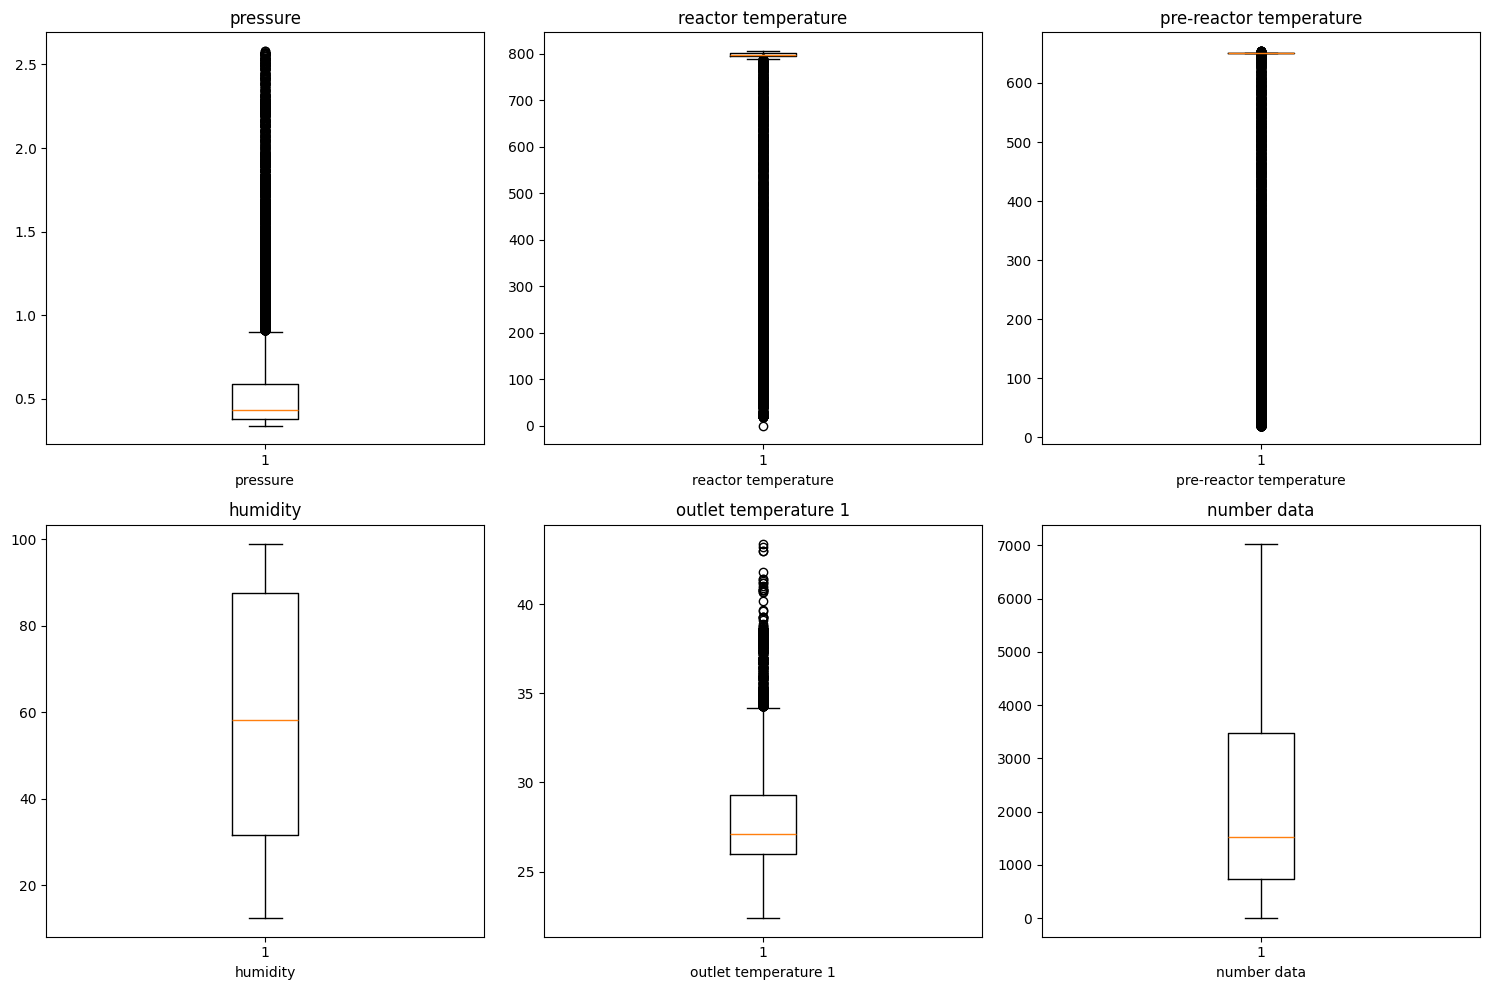

In [9]:
printBoxPlot(df_data=df_all, l_remove=['label', 'SMA pressure forecast'])

### Vazão de saída

Apenas 3 bases ['2024-01-23', '2024-03-14', '2024-03-15'] possuem valores produzidos por um medidor de vazão de saída instalado na saída de gás do reator o que totaliza 3871 registros. 

Elencamos as seguintes considerações:

- Outlet temperature 2 possui valores menores que outlet temperature1. Possivelmente por que o medidor de vazão está instalado após o medidor de umindade na linha de gás.
- Volume flow: possui um desvio padrão elevado (2.08), especialmente em relação ao seu valor médio (1.16). Isso sugere que os dados de fluxo de volume podem estar bastante dispersos. Pelo boxplot observemos que o fluxo de volume do gás atinge valores elevados, possivelmente durante o periodo em que o gás está sendo gerado pelo reator da reforma.
- Do mesmo modo, mass flow:  o valor máximo de 19.40 é muito superior à mediana (0.20), o que sugere que há momentos em que o fluxo de massa atinge valores elevados, possivelmente durante o periodo em que o gás está sendo gerado pelo reator da reforma.

In [10]:
df_all_flow[['outlet pressure', 'volume flow', 'mass flow', 'outlet temperature 2']].describe()

,outlet pressure,volume flow,mass flow,outlet temperature 2
count,3964.000000,3964.000000,3964.000000,3964.000000
mean,1.107578,1.301917,1.134687,24.788524
std,0.282535,2.338838,2.206203,2.217329
min,0.967000,0.000000,0.000000,17.180000
25%,0.973000,0.200000,0.200000,23.337500
50%,0.975000,0.200000,0.200000,25.030000
75%,0.976000,1.600000,1.000000,26.530000
max,2.046000,21.700000,19.400000,28.380000


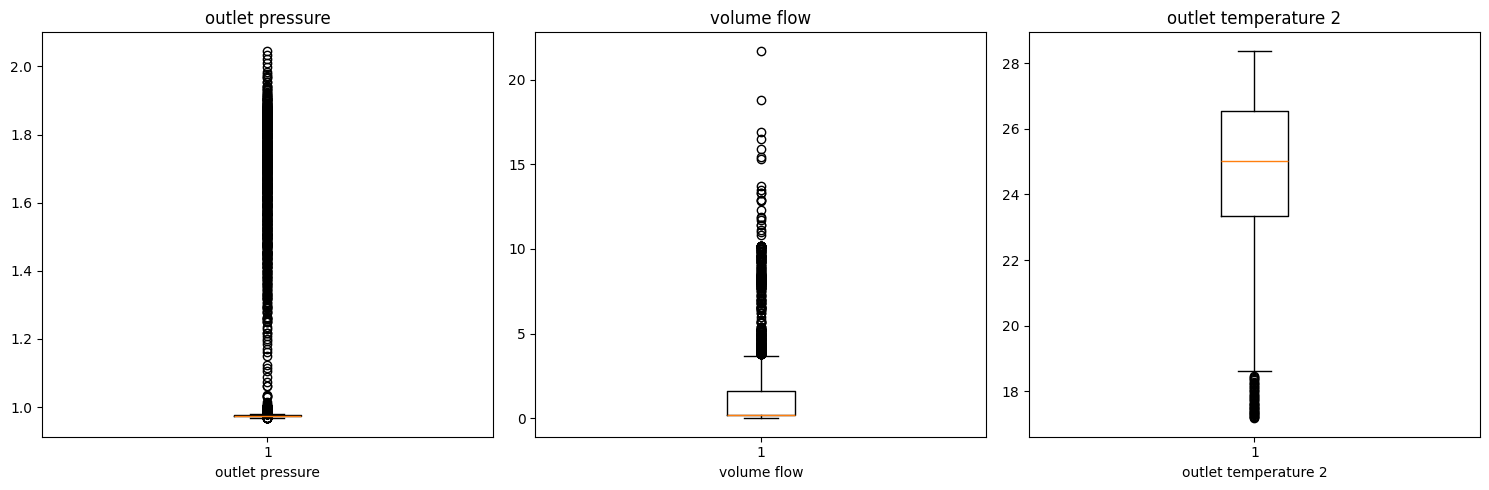

In [11]:
printBoxPlot(df_data=df_all_flow, l_remove=['pressure', 'reactor temperature', 'pre-reactor temperature', 'humidity', 'outlet temperature 1', 'label', 'number data', 'SMA pressure forecast', 'mass flow'])

### Simetria e curtose

- Pressão (Pressure): Alta assimetria positiva (2.677626), o que indica uma cauda longa à direita, e alta curtose (7.350852), sugerindo uma distribuição com picos elevados e caudas longas.
- Previsão da Pressão com SMA (SMA pressure forecast): Similar à pressão, com alta assimetria positiva (2.664879) e alta curtose (7.308521).
- Temperatura do Reator (Reactor temperature) e Temperatura Pré-Reator (Pre-reactor temperature): Assimetria negativa (-2.284833 e -2.248924, respectivamente), indicando caudas longas à esquerda. A curtose é positiva, o que sugere picos elevados.
- Umidade (Humidity): Quase simétrica (0.015083) com curtose negativa (-1.633470), indicando uma distribuição mais plana que a normal.
- Temperatura da Saída 1 (Outlet temperature 1): Assimetria positiva moderada (1.087410) e curtose ligeiramente acima de 1 (1.315148), sugerindo uma distribuição levemente desviada para a direita com uma distribuição mais achatada.
- Rótulo (label): Próximo da simetria (0.045623) com curtose negativa, sugerindo distribuições relativamente planas.

A partir do valores obtidos, essas análises indicam várias distribuições não-normais entre as variáveis, com várias delas apresentando caudas longas e picos pronunciados.

In [12]:
skewness = df_all.skew()
kurtosis = df_all.kurtosis()
stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
stats


,Skewness,Kurtosis
pressure,2.657343,7.248334
reactor temperature,-2.287172,3.468109
pre-reactor temperature,-2.251294,3.274922
humidity,0.009929,-1.632948
outlet temperature 1,1.091745,1.316905
label,0.044920,-1.404581
number data,0.829395,-0.375503
SMA pressure forecast,2.644193,7.202395


- Pressão da Saída (Outlet pressure): Alta assimetria positiva (1.898291), indicando uma cauda longa à direita, com uma curtose positiva (1.872754), sugerindo uma distribuição levemente mais picada do que a normal.
- Fluxo de Volume (Volume flow): Muito alta assimetria positiva (2.711252), indicando uma cauda longa à direita. A curtose é bastante alta (7.975606), o que sugere uma distribuição com picos elevados e caudas longas.
- Fluxo de Massa (Mass flow): Novamente, muito alta assimetria positiva (3.301427) com uma curtose extremamente alta (11.235368), sugerindo uma distribuição com picos ainda mais acentuados e caudas longas.
- Temperatura da Saída 2 (Outlet temperature 2): Assimetria negativa moderada (-0.786091), indicando uma cauda longa à esquerda, e curtose ligeiramente acima de 0 (0.278053), indicando uma distribuição próxima da normal, mas um pouco mais plana.

In [13]:
skewness = df_all_flow.skew()
kurtosis = df_all_flow.kurtosis()
stats = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
stats.head(n=4)


,Skewness,Kurtosis
outlet pressure,1.808542,1.584311
volume flow,2.764092,8.922194
mass flow,2.986247,8.809102
outlet temperature 2,-0.776970,0.266432


### Histogramas

A partir dos histogramas conseguimos ver a distribuição dos dados, além dos insights dos valores de Simetria e Curtose.

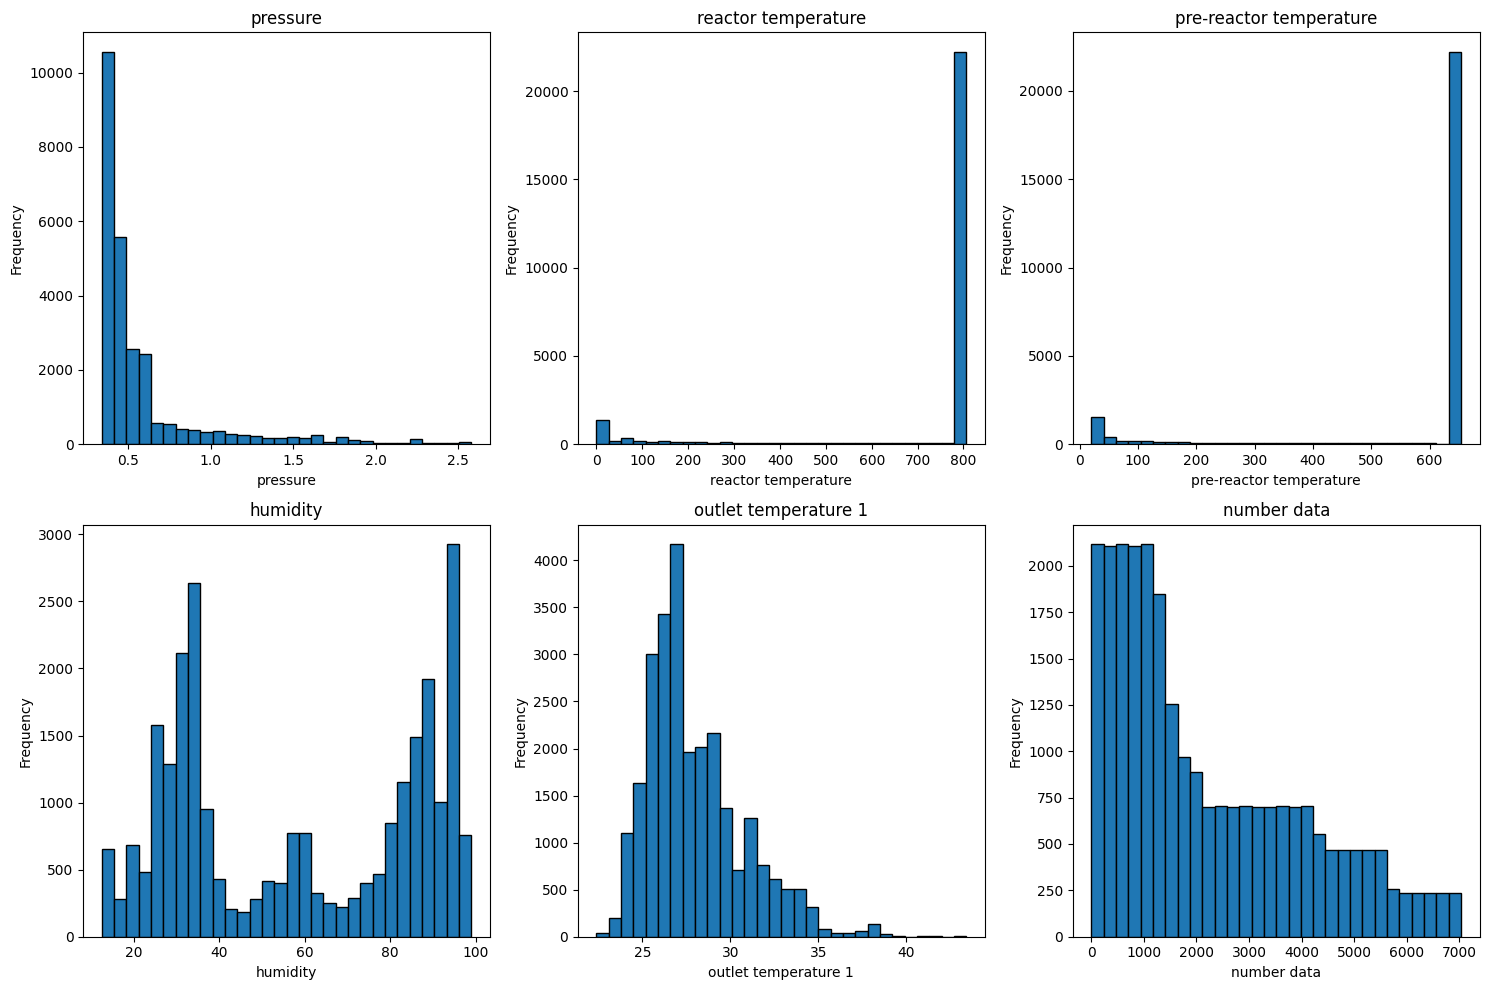

In [14]:
def printHistogram(df_data, l_remove):
    num_columns = len(df_data.columns)- len(l_remove)
    num_rows = math.ceil(num_columns / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axs = axs.flatten()
    k = 0
    for i, column in enumerate(df_data.columns):
        if column not in l_remove:
            axs[i-k].hist(df_data[column].dropna(), bins=30, edgecolor='black')
            axs[i-k].set_title(f'{column}')
            axs[i-k].set_xlabel(f'{column}')
            axs[i-k].set_ylabel('Frequency')
        else:
            k +=1

    # Removendo subplots vazios (se houver)
    for j in range(i-k+1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustando o layout
    plt.tight_layout()

    # Exibindo o gráfico
    plt.show()

printHistogram(df_data=df_all, l_remove=['label', 'SMA pressure forecast'])

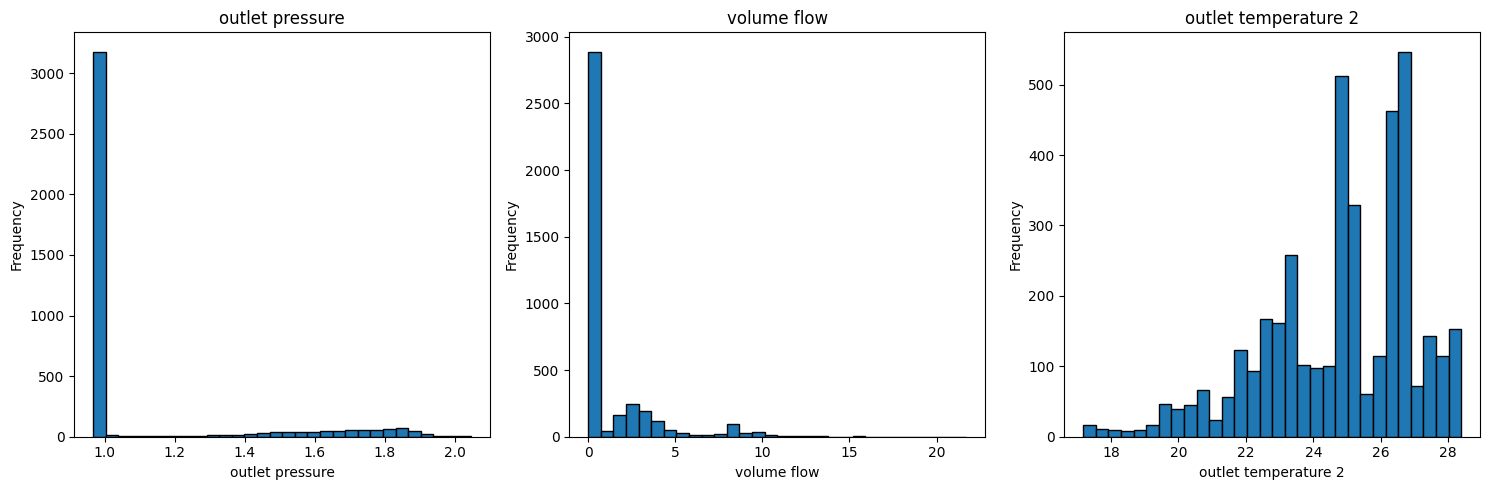

In [15]:
printHistogram(df_data=df_all_flow, l_remove=['pressure', 'reactor temperature', 'pre-reactor temperature', 'humidity', 'outlet temperature 1', 'label', 'number data', 'SMA pressure forecast', 'mass flow'])

### Teste de normalidade shapiro-wilk

- Os resultados da aplicação do teste de Shapiro-Wilk a cada um dos campos nos conjuntos de dados, onde todas as colunas foram rejeitas.
- Impacto direto a modelos que assume normaldiade dos dados (Regressão Linear e Analise Discriminante Linear)
- Modelos que não exigem normalidade de dados podem ter melhor desempenho (Decision Tree, RandomForest e Gradient Boosting)

In [16]:
result = []

for column in df_all_flow.columns:
    stat, p = shapiro(df_all_flow[column].dropna())
    result.append({'Column': column, 'Stat': stat, 'p-value': p, 'Normal': p > 0.05})

result_df = pd.DataFrame(result)

print(result_df)

                     Column      Stat       p-value  Normal
0           outlet pressure  0.522458  1.061925e-73   False
1               volume flow  0.577607  3.366254e-71   False
2                 mass flow  0.517033  6.217508e-74   False
3      outlet temperature 2  0.948832  4.261538e-35   False
4                  pressure  0.712239  1.158868e-63   False
5       reactor temperature  0.445859  8.604895e-77   False
6   pre-reactor temperature  0.443150  6.796726e-77   False
7                  humidity  0.817987  3.111072e-55   False
8      outlet temperature 1  0.893420  3.640857e-46   False
9                     label  0.679283  9.520516e-66   False
10              number data  0.960842  1.873203e-31   False
11    SMA pressure forecast  0.715738  3.446789e-63   False


### Matriz de Correlação

- Excluindo a diagonal principal, apenas 9 das 28 correlações apresentam maiores valores de correlação.
- Desconsiderar a alta correlação da média móvel da pressão com a pressão, por ser um dado derivado do outro.
- Uma alta correlação entre a temperatura do pré-forno com a temperatura do pré-forno, devido ao seu comportamento espelhado durante a operação. Lembrando de sua relêvancia, por se tratar de dados de pontos diferentes tendo resistencias elétricas individuais para aquecimento do reator e do pré-reator.

##### Mais afrente plotamos a matriz de correlação por base e criamos grupos de bases semelhantes

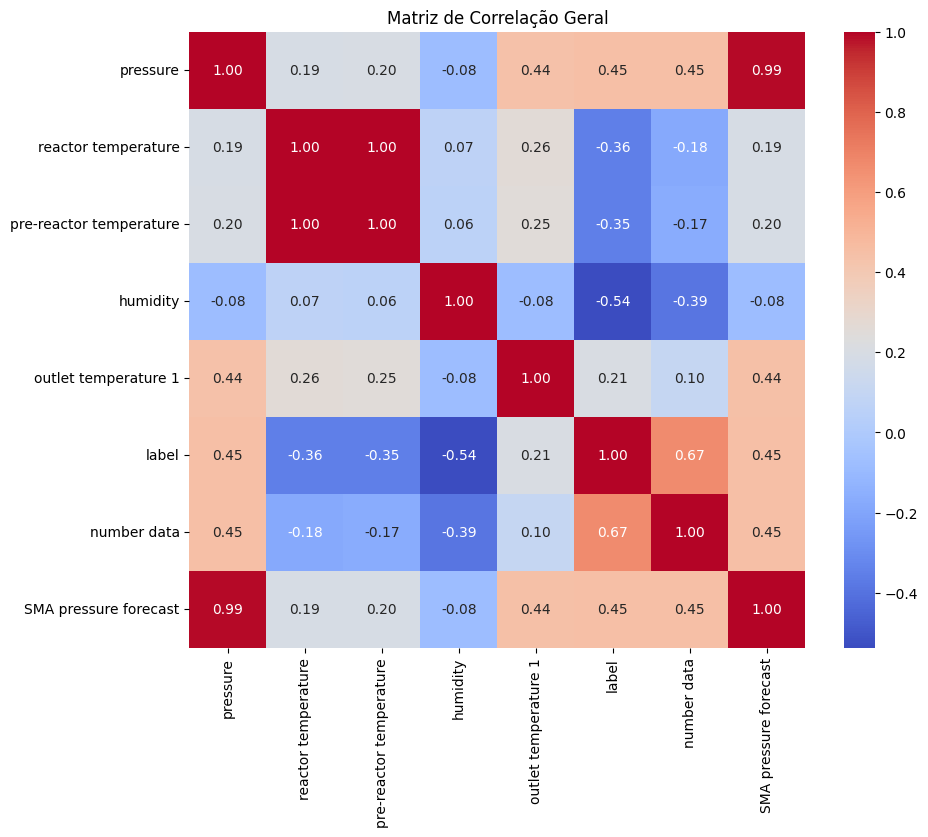

In [17]:
def plotCorrelation(correlation_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
    plt.title('Matriz de Correlação Geral')
    plt.show()

plotCorrelation(df_all.corr())

In [18]:
def getAllCorrelation(dfs):
    lCorr = []
    lSamples = []
    for i, df in enumerate(dfs):
        corr = df.corr()
        lCorr.append(corr)
        lSamples.append(df.shape[0])
    return lCorr, lSamples

In [19]:
def getClusterCorrMatrix(lCorr, lSample, normalized_dfs, dfsDisp):
    n_clusters=4

    flattened_matrices = [matrix.values.flatten() for matrix in lCorr]
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters, random_state=42) 

    kmeans.fit(flattened_matrices)

    labels = kmeans.labels_
    dfCluster = pd.DataFrame({'Base': days, 'id': idBase, 'Cluster': labels, 'Corr':lCorr, 'Amostras':lSample, 'dataNorm': normalized_dfs, 'dfDisp': dfsDisp})
    dfCluster = dfCluster.sort_values(by='Cluster')
    dfCluster = dfCluster.reset_index(drop=True)

    return dfCluster

In [20]:
def printCorrelationMatrix(dfCluster):
    plt.figure(figsize=(15, 10))

    j=0

    for i in range(0,dfCluster.shape[0]):
        plt.subplot(3, 3, i + 1)  
        corr = dfCluster['Corr'][i]

        if i<6:
            if i%3 !=0:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=[], yticklabels=[],
                            cbar_kws={"shrink": .8}, center=0)
            else:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=[], yticklabels=df_all.columns,
                            cbar_kws={"shrink": .8}, center=0)
        else:
            if i%3 !=0:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=df_all.columns, yticklabels=[],
                            cbar_kws={"shrink": .8}, center=0)
            else:
                sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                            xticklabels=df_all.columns, yticklabels=df_all.columns,
                            cbar_kws={"shrink": .8}, center=0)


        plt.title('Base ('+str(dfCluster['id'][i])+'): ' + dfCluster['Base'][i] + ', samples: '+str(dfCluster['Amostras'][i])+ ", cluster: " + str(dfCluster['Cluster'][i]))
        j+=1

    plt.tight_layout()
    plt.show()

In [21]:
def plot_data_1(dataset_idx, df, normalized_df):
    plt.figure(figsize=(10, 5))

    base_cmap = plt.colormaps.get_cmap('tab10')
    colors = ListedColormap(base_cmap.colors[:len(normalized_df.columns)])

    for idx, col in enumerate(normalized_df.columns):
        if col != 'label':
            plt.plot(normalized_df[col], label=col, color=colors(idx), alpha=0.7)

    previous_value = None
    first_label = True
    for i, value in enumerate(df['label']):
        if first_label:
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')
            first_label = False
        elif previous_value is not None and value != previous_value:
            plt.axvline(x=i, color='black', linestyle='--', alpha=0.5)
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')

        previous_value = value

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title(f'Dataset {dataset_idx:02d}')
    plt.xlabel('Number Data')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

In [22]:
dataframes = []

for idx in idBase:
    df = pd.read_csv(dir+'base'+str(idx)+'.csv')
    df = df.drop(['number data', 'local temperature', 'SMA pressure forecast'], axis=1)
    dataframes.append(df)

total_df = pd.concat(dataframes, ignore_index=True)

min_values = total_df.min()
max_values = total_df.max()
normalized_dfs = [(df - min_values) / (max_values - min_values) for df in dataframes]

description_map = {0: 'Activation', 1: 'Reaction', 2: 'Irregularity'}

### Matriz de correlação individual das bases

- Além da correlação individual por base, também foi realizado um agrupamento entre as matrizes de correlação, com o objetivo de identificar similaridades entre as bases. O agrupamento foi realizado com o k-means, com k=4.
- A ideia de criar clusters é para verificar similaridades entre as bases que estão sendo trabalhadas.
- Cluster 0 (base 23 e 24): Possuem 3 estágios, ativação, reação e irregularidade.
- Cluster 1 (base 21, 22 e 26): As bases 21 e 22 parecem mais similares. Possuem 2 estágios ativação e reação. A base 26 destoa possuindo vários estágios.
- Cluster 2 (base 17 e 27): Possuem dois estágios ativação e irregularidade e o gráfico de dispersão é similar.
- Couster 3 (base 30 e 39): Possuem dois estagios ativação e reação e grafico de dispersão similares.

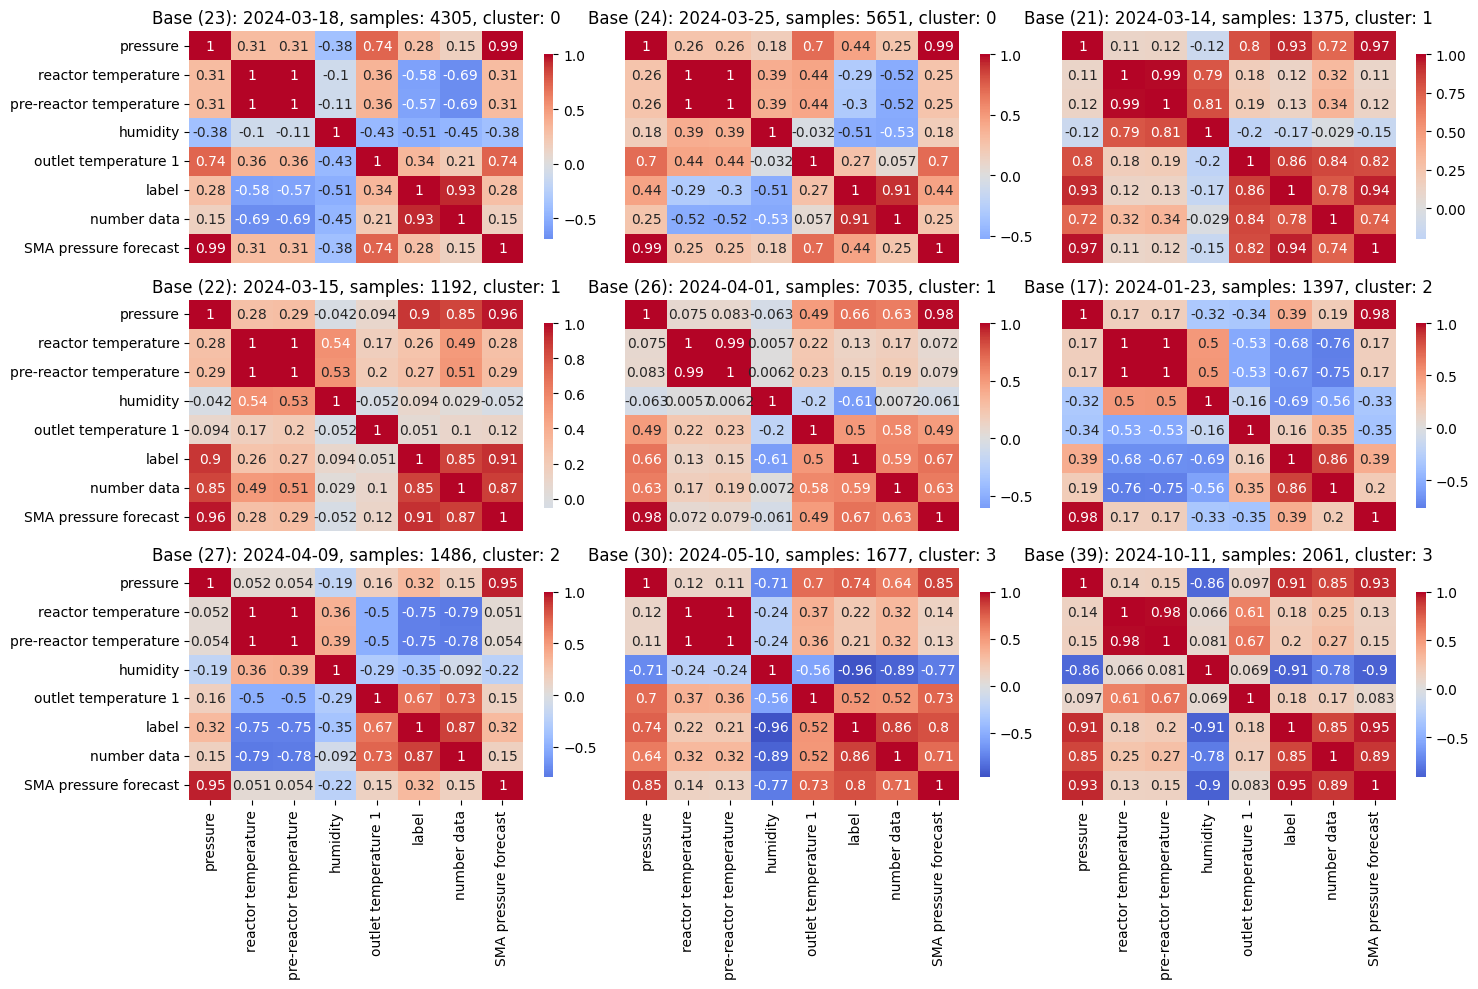

In [23]:
lCorr, lSample = getAllCorrelation(dfs=dfs)
dfCluster = getClusterCorrMatrix(lCorr=lCorr, lSample=lSample, normalized_dfs=normalized_dfs, dfsDisp=dataframes)
printCorrelationMatrix(dfCluster)

### Grafico de dispersão

- Nos gráficos abaixo, as bases são plotadas individualmente, com os dados de Pressão, Temperatura do Reator, Temperatura do Pré-Reator e Umidade (os principais dados usados para a rotulagem das bases).

- As linhas tracejadas verticais separam os rótulos que identificam os status de operação (Activation, Reaction and Irrgularity).

- Mesmo sendo plotados individualmente, os dados foram normalizados com todas as bases juntas, para eliminar possíveis inconsistências. Assim, obtivemos uma melhor representatividade do perfil dos dados para cada status de operação.


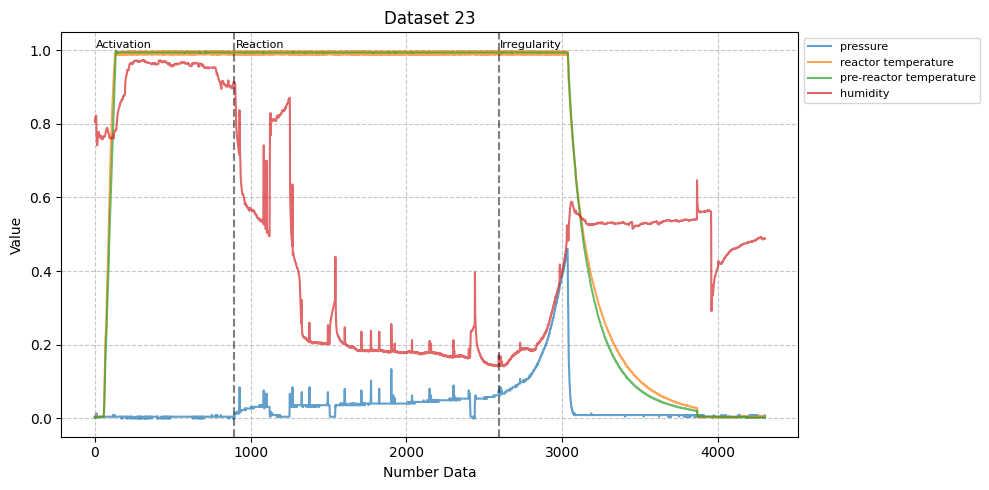

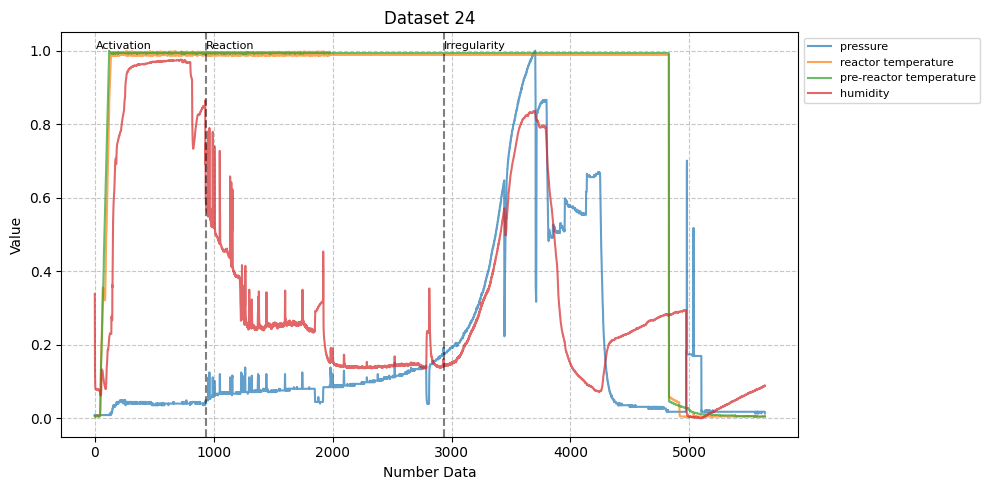

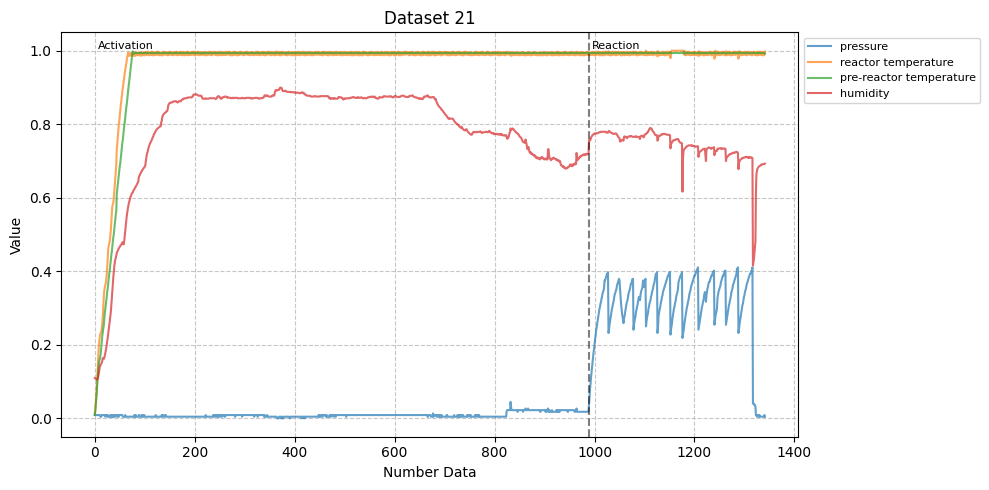

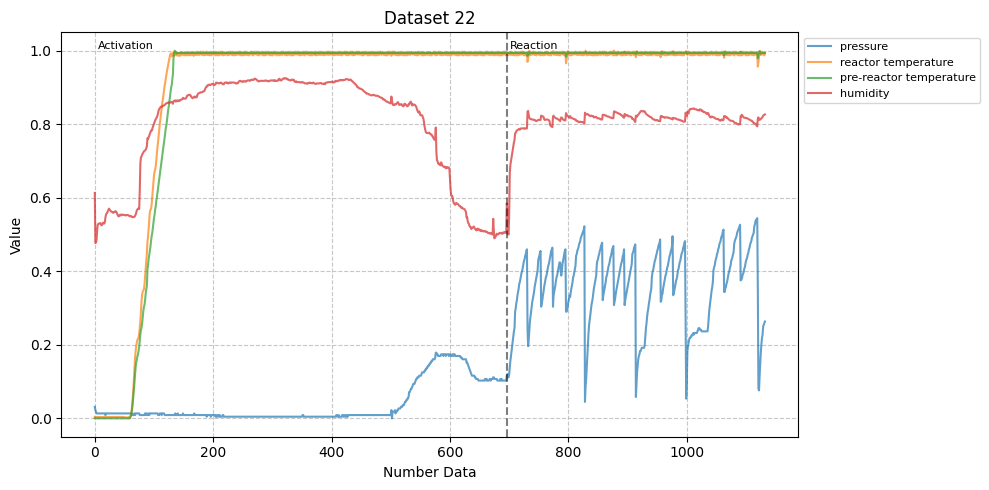

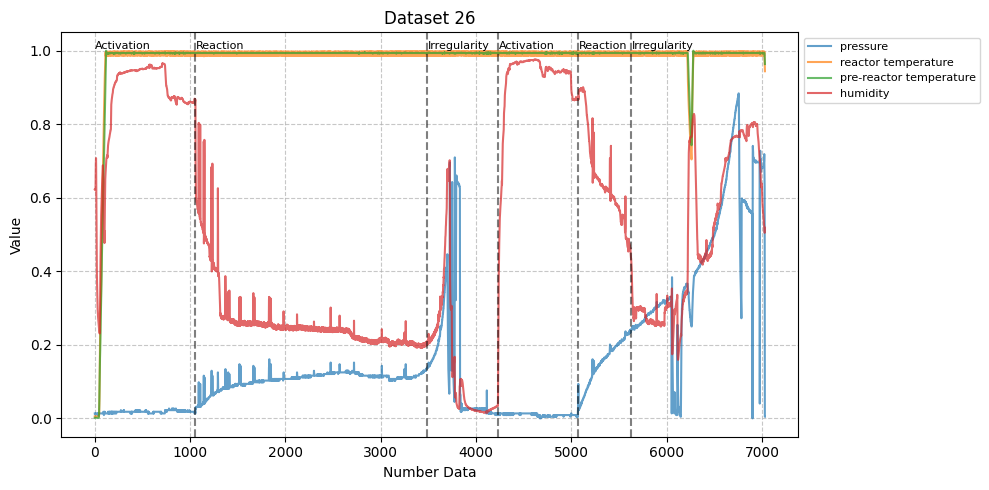

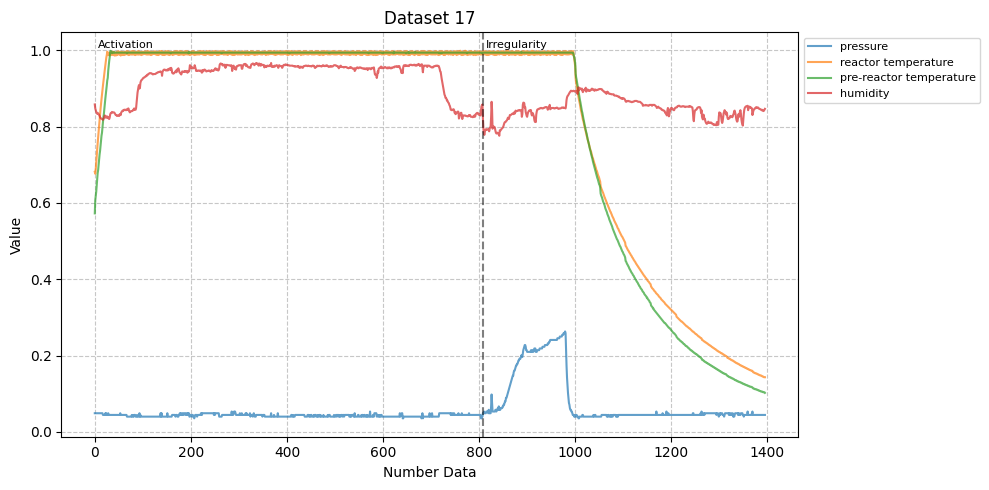

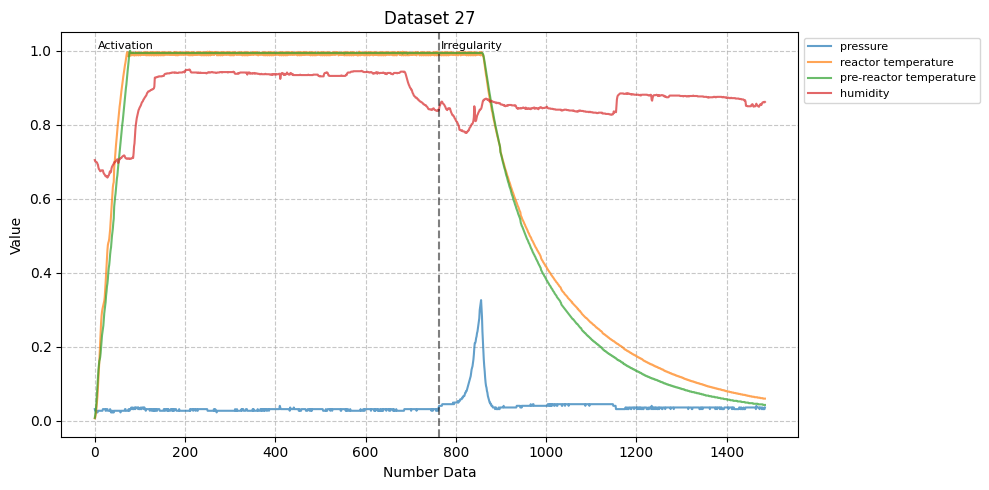

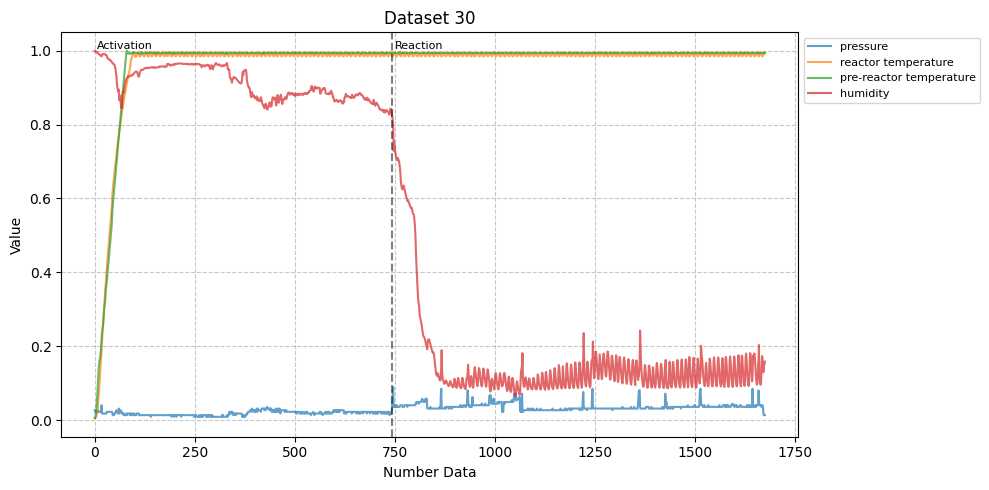

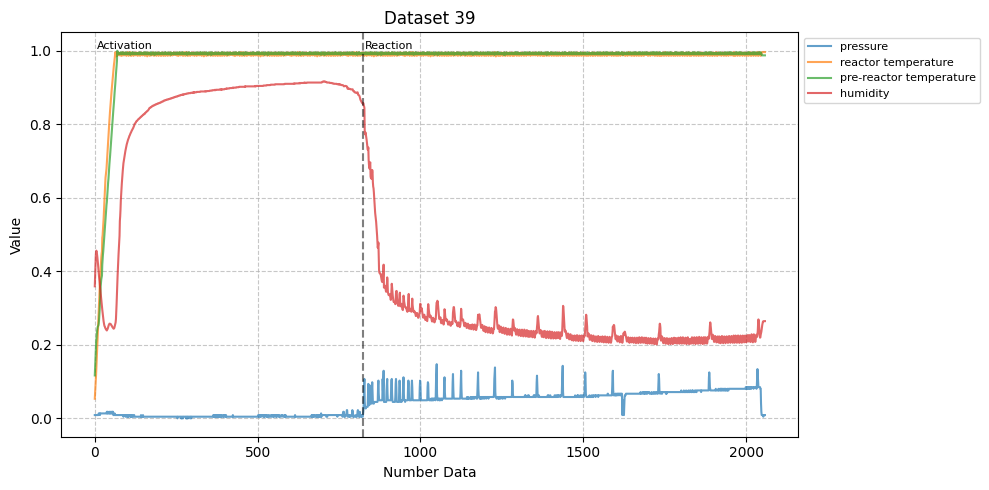

In [24]:
for idx, (dataset_idx, df, normalized_df) in enumerate(zip(dfCluster['id'], dfCluster['dfDisp'], dfCluster['dataNorm'])):
  plot_data_1(dataset_idx, df, normalized_df)

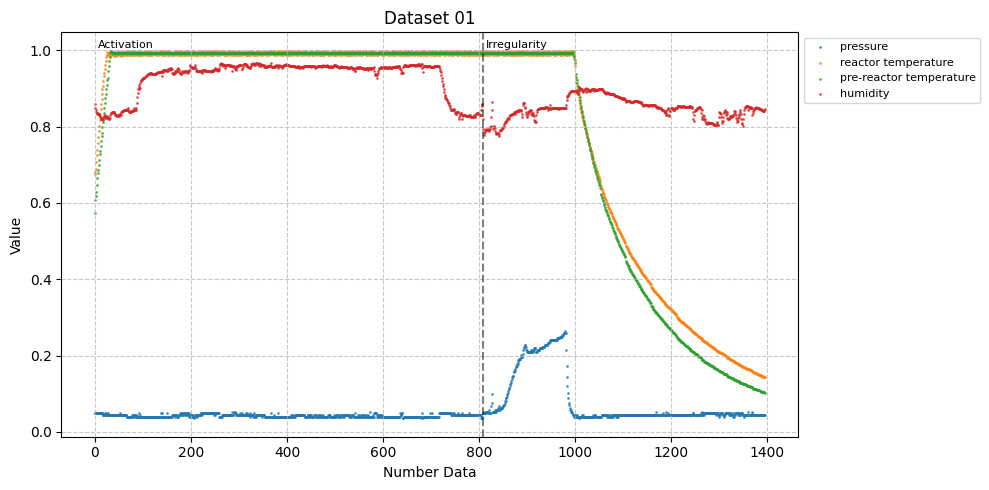

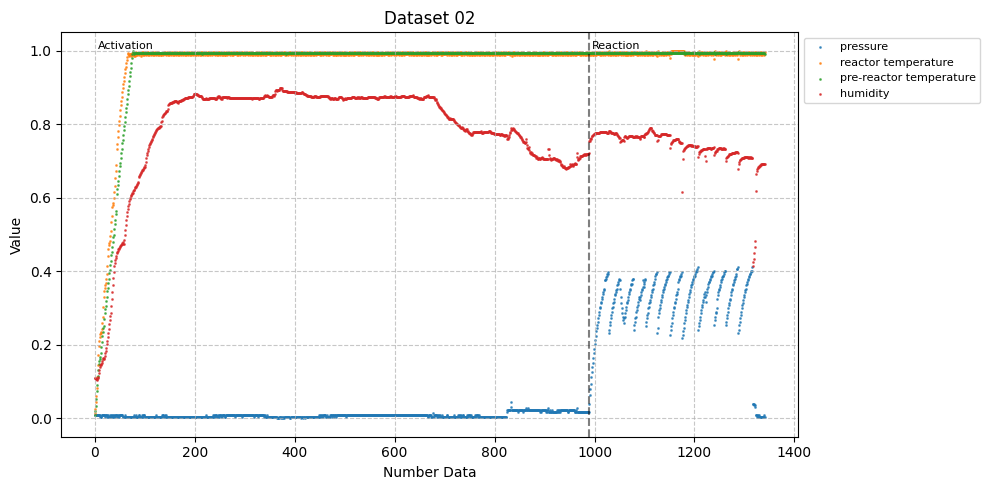

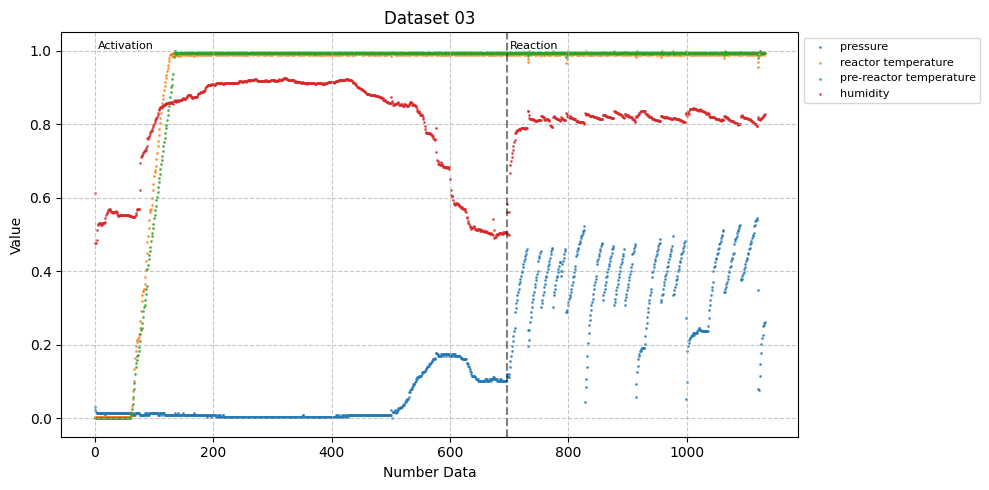

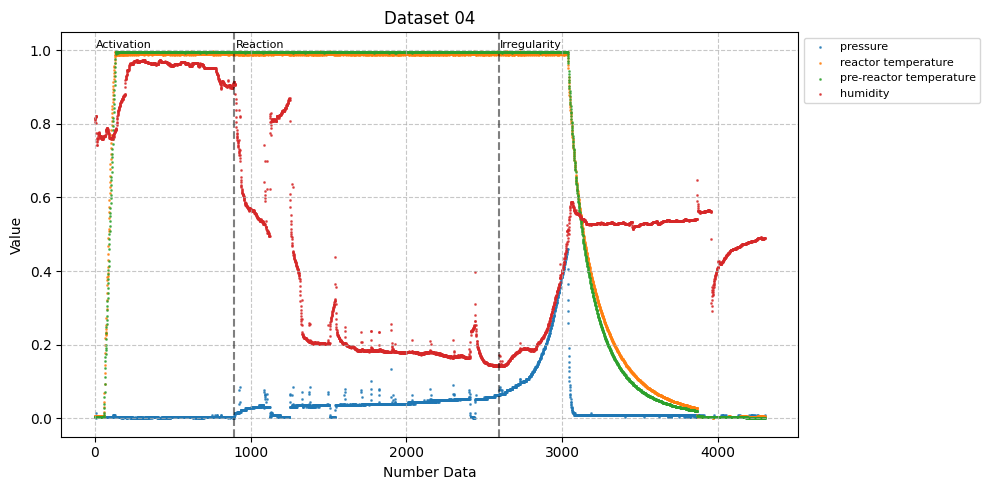

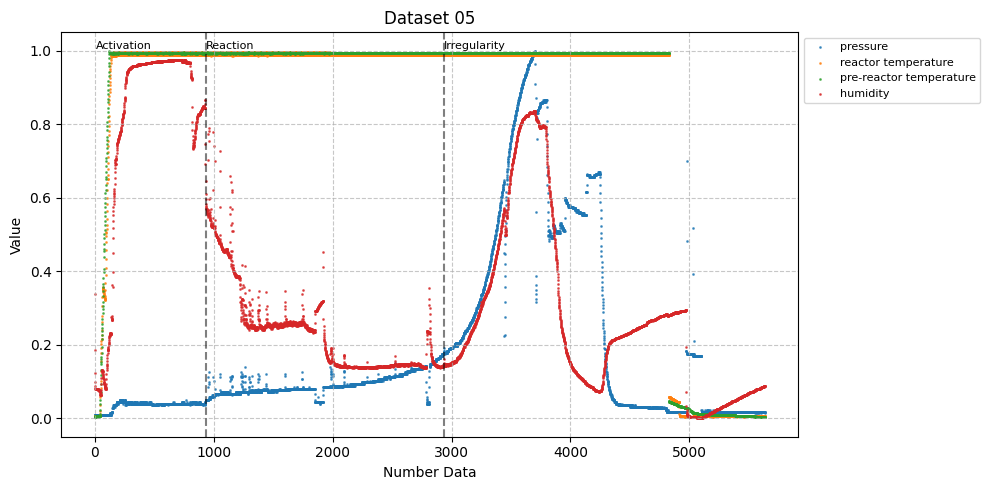

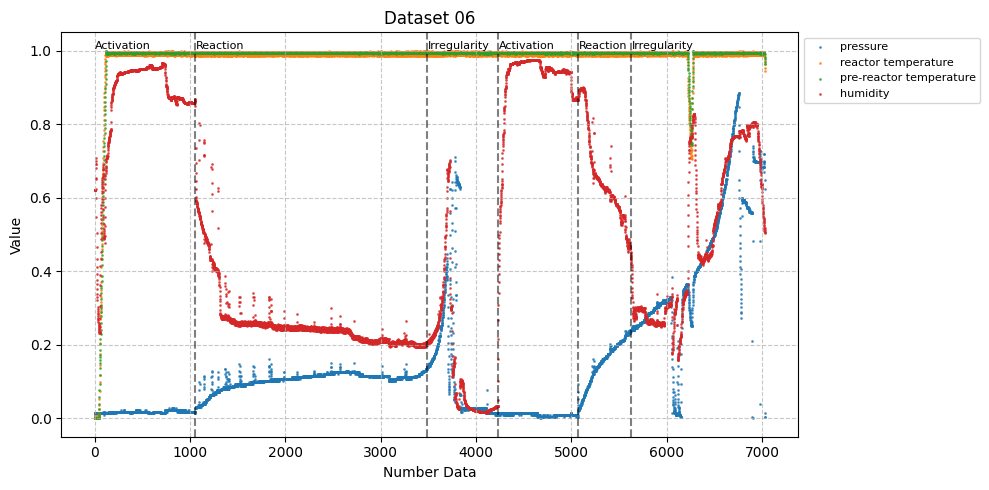

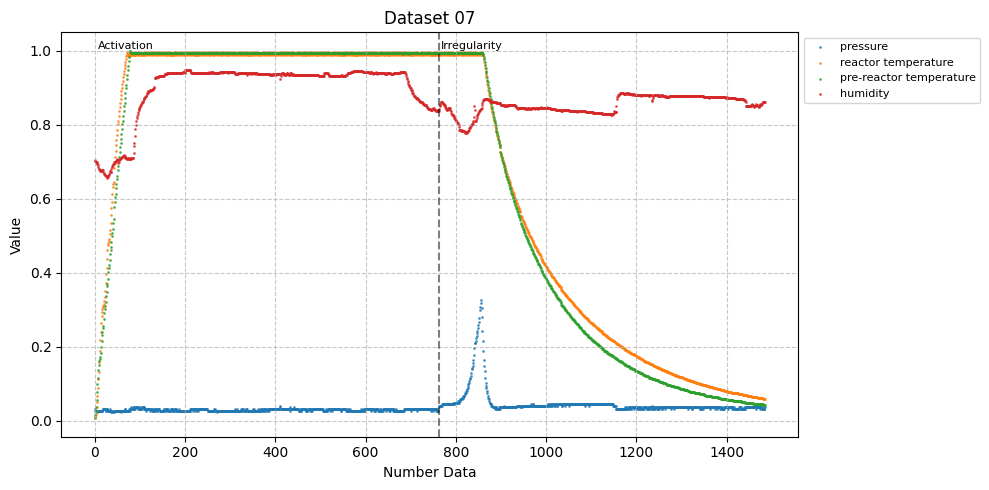

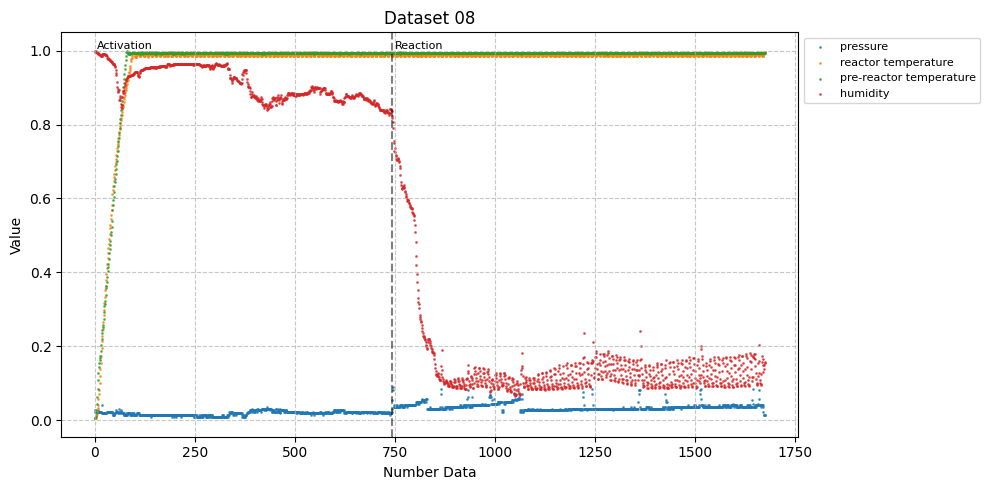

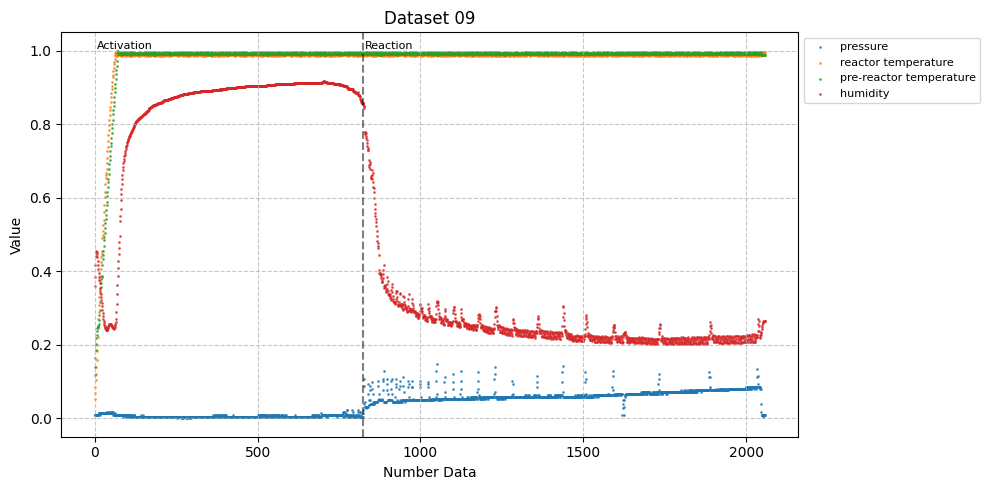

In [25]:
def plot_data_2(dataset_idx, df, normalized_df):
    plt.figure(figsize=(10, 5))

    base_cmap = plt.colormaps.get_cmap('tab10')
    colors = ListedColormap(base_cmap.colors[:len(normalized_df.columns)])

    for idx, col in enumerate(normalized_df.columns):
        if col != 'label':
            plt.scatter(range(len(normalized_df[col])), normalized_df[col], label=col, color=colors(idx), s=1, alpha=0.7)

    previous_value = None
    first_label = True
    for i, value in enumerate(df['label']):
        if first_label:
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')
            first_label = False
        elif previous_value is not None and value != previous_value:
            plt.axvline(x=i, color='black', linestyle='--', alpha=0.5)
            plt.text(i + 6, normalized_df.max().max(), description_map[value],
                     rotation=0, verticalalignment='bottom', horizontalalignment='left', fontsize=8, color='black')

        previous_value = value

    plt.grid(True, linestyle='--', alpha=0.7)

    plt.title(f'Dataset {dataset_idx:02d}')
    plt.xlabel('Number Data')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

for idx, (dataset_idx, df, normalized_df) in enumerate(zip([1, 2, 3, 4, 5, 6, 7, 8, 9], dataframes, normalized_dfs)):
    plot_data_2(dataset_idx, df, normalized_df)

### Matriz de Correlação com Vazao

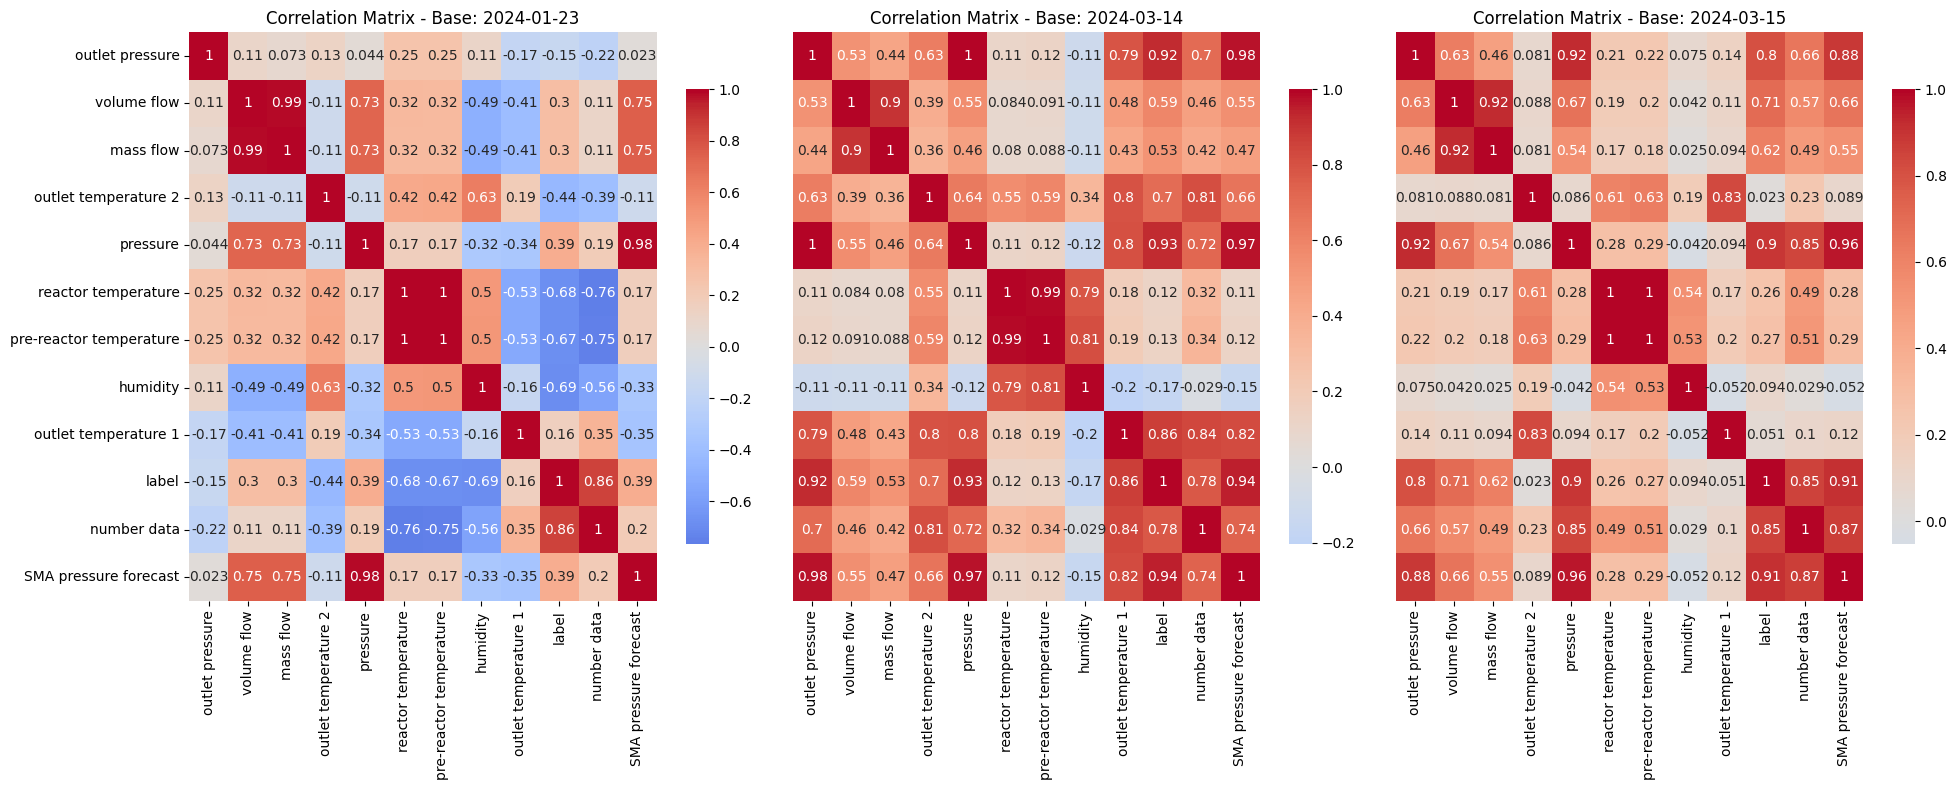

In [26]:
plt.figure(figsize=(20, 8))

# Iterar sobre as bases de dados e plotar os mapas de calor
j=0
lCorr = []
lNAmostras = []
for i, df in enumerate(dfs_flow):
    plt.subplot(1, 3, i + 1)  # Organizando em uma grade 3x3
    corr = df.corr()  # Calcular a matriz de correlação
    lCorr.append(corr)
    lNAmostras.append(df.shape[0])
    if i==0:
        sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                xticklabels=df.columns, yticklabels=df.columns,
                cbar_kws={"shrink": .8}, center=0)
    else:
        sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True,
                    xticklabels=df.columns, yticklabels=[],
                    cbar_kws={"shrink": .8}, center=0)


    plt.title('Correlation Matrix - Base: ' + days_flow[i])
    j+=1

plt.tight_layout()  # Ajustar o layout para evitar sobreposição
plt.show()